In [1]:
#!pip install textblob
#!pip install pyLDAvis
#!pip install matplotlib
#!pip install gensim --upgrade
#!pip install pyLDAvis --upgrade

In [2]:
import os
import time
import math
import re
from pprint import pprint
from textblob import TextBlob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


import nltk as nltk
from nltk.corpus import stopwords
# from nltk.stem.wordnet import WordNetLemmatizer
import spacy
import multiprocessing
import string


import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# import pyLDAvis.gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)
import matplotlib.pyplot as plt

#### Read news data

In [3]:
news_path = 'https://storage.googleapis.com/msca-bdp-data-open/news/nlp_a_6_news.json'
news_df = pd.read_json(news_path, orient='records', lines=True)


print(f'Sample contains {news_df.shape[0]:,.0f} news articles')
news_df.head(2)

Sample contains 9,962 news articles


,url,date,language,title,text
0,http://oaklandnewsnow.com/breaking-bts-announces-las-vegas-us-concert-date-in-2022/,2022-02-24,en,"BREAKING: BTS Announces LAS VEGAS, US Concert Date in 2022! | Oakland News Now - Oakland News, SF Bay Area, East Bay, California, World","BREAKING: BTS Announces LAS VEGAS, US Concert Date in 2022! | Oakland News Now - Oakland News, SF Bay Area, East Bay, California, WorldSorry, you have Javascript Disabled! To see this page as it is meant to appear, please enable your Javascript!BREAKING: BTS Announces LAS VEGAS, US Concert Date in 2022! | Oakland News Now - Oakland News, SF Bay Area, East Bay, California, WorldSkip to contentMenuSearch for:SearchOakland News Now – Oakland News, SF Bay Area, East Bay, California, WorldOakland..."
1,http://www.newsdzezimbabwe.co.uk/2022/04/mai-tt-weds.html,2022-04-09,en,MAI TT WEDS newsdzeZimbabweNewsdzeZimbabwe,"MAI TT WEDS newsdzeZimbabweNewsdzeZimbabweskip to main | skip to sidebarHomeAboutContactAdvertiseNewsdzeZimbabweOur Zimbabwe Our NewsHomeNewsBusinessEntertainmentSaturday, 9 April 2022MAI TT WEDSSaturday, April 09, 2022 NewsdzeZimbabwe 0 Best moments... @Chakariboy @NyamayaroArron @restmutore @Lattynyangu pic.twitter.com/MsrhcFXUJj— H-Metro (@HMetro_) April 9, 2022 Posted in: Share to TwitterShare to FacebookOlder PostHome0comments: Post a CommentFollow NewsdzeZimbabweRecent..."


#### Read Tweets data

In [2]:
tweets_path = 'https://storage.googleapis.com/msca-bdp-data-open/tweets/nlp_a_6_tweets.json'
tweets_df = pd.read_json(tweets_path, orient='records', lines=True)
print(f'Sample contains {tweets_df.shape[0]:,.0f} tweets')
tweets_df.head(2)

Sample contains 9,941 tweets


,id,lang,date,name,retweeted,text
0,1484553027222741001,en,2022-01-21,Dylan Green,RT,*Microsoft has entered the chat* https://t.co/Uz3pZrk6B3
1,1505486305102557184,en,2022-03-20,Rahim Rajwani,,"""I actually use an @Android phone. Some #Android manufacturers pre-install @Microsoft software in a way that makes it easy for me. They’re more flexible about how the software connects up with the OS. So that’s what I ended up getting used to.""\nhttps://t.co/C0VjfS9PUO"


In [4]:

%%time 
news_df = news_df[news_df['language']=='en'].reset_index(drop=True)
tweets_df = tweets_df[tweets_df['lang']=='en'].reset_index(drop=True)
tweets_df = tweets_df[tweets_df['retweeted'] != "RT"]

NameError: name 'tweets_df' is not defined

In [5]:
start_time = time.time()

def tic():
    global start_time 
    start_time = time.time()

def tac():
    t_sec = round(time.time() - start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print(f'Execution time to calculate for topic {k}: {t_hour}hour:{t_min}min:{t_sec}sec'.format(t_hour,t_min,t_sec))

## News Text

In [11]:
%%time

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
        
data_list = news_df['text'].tolist()        
data_tokens = list(sent_to_words(data_list))

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 11 µs


"data_list = news_df['text'].tolist()        \ndata_tokens = list(sent_to_words(data_list))"

In [8]:
news_df.head()

,url,date,language,title,text
0,http://oaklandnewsnow.com/breaking-bts-announces-las-vegas-us-concert-date-in-2022/,2022-02-24,en,"BREAKING: BTS Announces LAS VEGAS, US Concert Date in 2022! | Oakland News Now - Oakland News, SF Bay Area, East Bay, California, World","BREAKING: BTS Announces LAS VEGAS, US Concert Date in 2022! | Oakland News Now - Oakland News, SF Bay Area, East Bay, California, WorldSorry, you have Javascript Disabled! To see this page as it is meant to appear, please enable your Javascript!BREAKING: BTS Announces LAS VEGAS, US Concert Date in 2022! | Oakland News Now - Oakland News, SF Bay Area, East Bay, California, WorldSkip to contentMenuSearch for:SearchOakland News Now – Oakland News, SF Bay Area, East Bay, California, WorldOakland..."
1,http://www.newsdzezimbabwe.co.uk/2022/04/mai-tt-weds.html,2022-04-09,en,MAI TT WEDS newsdzeZimbabweNewsdzeZimbabwe,"MAI TT WEDS newsdzeZimbabweNewsdzeZimbabweskip to main | skip to sidebarHomeAboutContactAdvertiseNewsdzeZimbabweOur Zimbabwe Our NewsHomeNewsBusinessEntertainmentSaturday, 9 April 2022MAI TT WEDSSaturday, April 09, 2022 NewsdzeZimbabwe 0 Best moments... @Chakariboy @NyamayaroArron @restmutore @Lattynyangu pic.twitter.com/MsrhcFXUJj— H-Metro (@HMetro_) April 9, 2022 Posted in: Share to TwitterShare to FacebookOlder PostHome0comments: Post a CommentFollow NewsdzeZimbabweRecent..."
2,https://digg.com/video/heres-an-eye-popping-visualization-of-how-covid-19-enters-a-human-cell,2022-01-07,en,Here's An Eye-Popping Visualization Of How COVID-19 Enters A Human Cell - Digg,"Here's An Eye-Popping Visualization Of How COVID-19 Enters A Human Cell - DiggTrendingExploreMerchExploreMerchSign inClose menuGift GuidesVideoGamingPicksSportsLong ReadsTechCultureScienceRelationshipsSign in to your Digg account.Sign in with TwitterSign in with GoogleBy signing in you agree with ourcommunications and usage terms.Not a member yet? Sign up👋 Welcome to DiggThanks for creating an account! Your accounts lets you Digg (upvote) stories, save stories to revisit later, and more.📩 St..."
3,https://economictimes.indiatimes.com/news/international/world-news/taliban-shut-down-schools-for-girls-just-hours-after-they-reopened/articleshow/90406043.cms,2022-03-23,en,taliban: Taliban shut down schools for girls just hours after they reopened - The Economic Times,"taliban: Taliban shut down schools for girls just hours after they reopened - The Economic Times Benchmarks Nifty17,245.65-69.85NSE Gainer-Large Cap Linde India3,508.05175.35FEATURED FUNDS★★★★★Mirae Asset Hybrid Equity Fund Direct-Growth5Y Return14.62 % Invest NowFEATURED FUNDS★★★★★Mirae Asset Equity Savings Fund Direct - Growth3Y Return13.38 % Invest NowMarket WatchNewsEnglish Edition | E-PaperSubscribeSign InET Prime starts @ Rs 49The Great Holi OfferUpgrade..."
4,https://federalnewsnetwork.com/world-news/2022/06/scotland-leader-launches-campaign-for-new-independence-vote/,2022-06-14,en,Scotland leader launches campaign for new independence vote | Federal News Network,Scotland leader launches campaign for new independence vote | Federal News Network TechnologyArtificial IntelligenceAsk the CIOAutomationBig DataCIO NewsCloud ComputingCybersecurityIT ModernizationOpen Data/TransparencyReporter’s NotebookDefenseDoD Reporter’s NotebookOn DoDArmyNavyAir ForceDefense IndustryWorkforce/ManagementAcquisitionAgency OversightBudgetFacilities/ConstructionHiring/RetentionManagementPeopleReorganizationSESUnionsWorkforce Rights/GovernancePay & BenefitsBenefitsOpen Se...


In [9]:
%%time

# bigram = gensim.models.Phrases(data_tokens, min_count=5, threshold=100)
# trigram = gensim.models.Phrases(bigram[data_tokens], threshold=100)

bigram = gensim.models.Phrases(data_tokens, min_count=1, threshold=1)
trigram = gensim.models.Phrases(bigram[data_tokens], threshold=1)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

CPU times: user 55.8 s, sys: 394 ms, total: 56.2 s
Wall time: 56.2 s


In [12]:
%%time

stop_words = stopwords.words('english')

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

CPU times: user 466 µs, sys: 718 µs, total: 1.18 ms
Wall time: 632 µs


In [12]:
%%time

# Remove Stop Words
data_tokens_nostops = remove_stopwords(data_tokens)

# Create n-grams
data_words_bigrams = make_bigrams(data_tokens_nostops)
data_words_trigrams = make_trigrams(data_tokens_nostops)

# Combine tokens and n-grams
# data_tokens_cobnined = data_tokens_nostops + data_words_bigrams + data_words_trigrams
data_tokens_cobnined = data_words_trigrams

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Lemmatize text keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_tokens_cobnined, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


CPU times: user 9min 35s, sys: 12 s, total: 9min 47s
Wall time: 9min 50s


In [13]:
%%time

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(data_lemmatized)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_lemmatized]

CPU times: user 7.56 s, sys: 79.3 ms, total: 7.64 s
Wall time: 7.67 s


In [13]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=k,
                       random_state=100,                  
                       passes=10,
                       alpha=a,
                       eta=b,
                       workers=workers)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [19]:
%%time

grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 20
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')
alpha = ['asymmetric'] # Run for number of topics only

# Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')
beta = ['auto'] # Run for number of topics only


# Validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [# gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.5), 
#                gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.75), 
               doc_term_matrix]
# corpus_title = ['75% Corpus', '100% Corpus']
corpus_title = ['100% Corpus']
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')

    
# iterate through hyperparameters
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        tic()
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                itr += 1
                cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                pct_completed = round((itr / itr_total * 100),1)
#                 print(f'Completed Percent: {pct_completed}%, Corpus: {corpus_title[i]}, Topics: {k}, Alpha: {a}, Beta: {b}, Coherence: {cv}')
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
        tac()
                    
lda_tuning = pd.DataFrame(model_results)

LDA will execute 19 iterations
Completed model based on 2 LDA topics. Finished 5.3% of LDA runs
Execution time to calculate for topic 2: 0hour:1min:22sec
Completed model based on 3 LDA topics. Finished 10.5% of LDA runs
Execution time to calculate for topic 3: 0hour:1min:22sec
Completed model based on 4 LDA topics. Finished 15.8% of LDA runs
Execution time to calculate for topic 4: 0hour:1min:24sec
Completed model based on 5 LDA topics. Finished 21.1% of LDA runs
Execution time to calculate for topic 5: 0hour:1min:30sec
Completed model based on 6 LDA topics. Finished 26.3% of LDA runs
Execution time to calculate for topic 6: 0hour:1min:31sec
Completed model based on 7 LDA topics. Finished 31.6% of LDA runs
Execution time to calculate for topic 7: 0hour:1min:34sec
Completed model based on 8 LDA topics. Finished 36.8% of LDA runs
Execution time to calculate for topic 8: 0hour:1min:34sec
Completed model based on 9 LDA topics. Finished 42.1% of LDA runs
Execution time to calculate for topi

In [18]:
num_processors = multiprocessing.cpu_count()
num_processors

workers = num_processors-1

print(f'Using {workers} workers')

Using 7 workers


In [20]:
lda_tuning.sort_values(by=['Coherence'], ascending=False).head(10)


,Topics,Alpha,Beta,Coherence
14,16,asymmetric,auto,0.466442
16,18,asymmetric,auto,0.463980
18,20,asymmetric,auto,0.460096
8,10,asymmetric,auto,0.459493
15,17,asymmetric,auto,0.459093
12,14,asymmetric,auto,0.455803
10,12,asymmetric,auto,0.454033
9,11,asymmetric,auto,0.450642
13,15,asymmetric,auto,0.449083
17,19,asymmetric,auto,0.449019


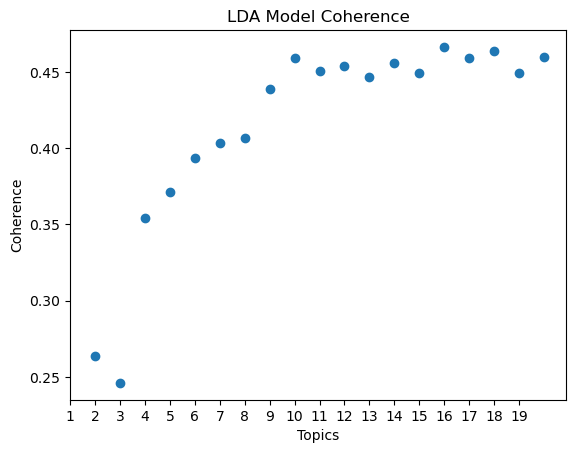

In [21]:
import matplotlib.pyplot as plt

plt.scatter(lda_tuning['Topics'], lda_tuning['Coherence'])
plt.xticks(range(1, 20))
plt.xlabel('Topics')
plt.ylabel('Coherence')
plt.title('LDA Model Coherence')
plt.show()

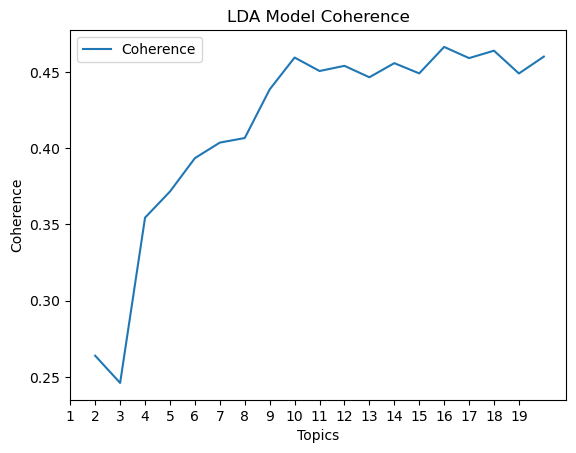

In [23]:
import matplotlib.pyplot as plt
lda_tuning.plot('Topics','Coherence')
plt.xticks(range(1, 20))
plt.xlabel('Topics')
plt.ylabel('Coherence')
plt.title('LDA Model Coherence')
plt.show()

In [24]:
%%time
lda_tuning_best = lda_tuning.sort_values(by=['Coherence'], ascending=False).head(1)


tuned_topics = int(lda_tuning_best['Topics'].to_string(index=False))


# Since the values for Alpha and Beta can be float, symmetric and asymmetric, we will either strip or convert to float
try:
    tuned_alpha = float(lda_tuning_best['Alpha'].to_string(index=False))
except:
    tuned_alpha = lda_tuning_best['Alpha'].to_string(index=False).strip()
    

try:
    tuned_beta = float(lda_tuning_best['Beta'].to_string(index=False))
except:
    tuned_beta = lda_tuning_best['Beta'].to_string(index=False).strip()    
    
print(f'Best Parameters: Topics: {tuned_topics}, Alpha: {tuned_alpha}, Beta: {tuned_beta}')

Best Parameters: Topics: 16, Alpha: asymmetric, Beta: auto
CPU times: user 5.38 ms, sys: 654 µs, total: 6.04 ms
Wall time: 6.18 ms


In [25]:
%%time

tuned_lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=13,
                       random_state=100,
                       passes=10,
                       alpha=tuned_alpha,
                       eta=tuned_beta,
                       workers = workers)

coherence_model_lda = CoherenceModel(model=tuned_lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
print('\nCoherence Score: ', coherence_model_lda.get_coherence())


Coherence Score:  0.4465475747241061
CPU times: user 1min 22s, sys: 1min 28s, total: 2min 51s
Wall time: 1min 51s


In [26]:
%%time
pprint(tuned_lda_model.print_topics())
doc_lda = tuned_lda_model[doc_term_matrix]

[(0,
  '0.009*"market" + 0.004*"provide" + 0.004*"sign" + 0.004*"company" + '
  '0.004*"information" + 0.004*"make" + 0.003*"forecast" + 0.003*"share" + '
  '0.003*"report" + 0.003*"article"'),
 (1,
  '0.004*"use" + 0.004*"get" + 0.003*"new" + 0.003*"need" + 0.003*"make" + '
  '0.003*"come" + 0.003*"game" + 0.003*"available" + 0.003*"say" + '
  '0.002*"see"'),
 (2,
  '0.011*"say" + 0.003*"year" + 0.003*"make" + 0.003*"time" + 0.003*"work" + '
  '0.003*"get" + 0.003*"go" + 0.003*"company" + 0.003*"people" + 0.002*"sell"'),
 (3,
  '0.051*"strip" + 0.042*"jpeg_source_url_https_media" + '
  '0.040*"height_filesize_mime_type_image" + 0.039*"resize_nbc_cc_file" + '
  '0.032*"resize_width" + 0.023*"com_pnbcstations_jpg_quality" + '
  '0.021*"quality_strip" + 0.011*"width_height_filesize_mime_type" + '
  '0.007*"resize_https" + 0.007*"pnbcstations_jpg"'),
 (4,
  '0.007*"game" + 0.007*"open" + 0.004*"make" + 0.004*"new" + 0.004*"year" + '
  '0.004*"get" + 0.003*"say" + 0.003*"company" + 0.003*"

In [27]:
%%time

lda_display = gensimvis.prepare(tuned_lda_model, doc_term_matrix, dictionary, sort_topics=False, mds='mmds',n_jobs=1)
pyLDAvis.display(lda_display)

CPU times: user 21.9 s, sys: 13.8 s, total: 35.7 s
Wall time: 19.1 s


## News Title

In [6]:
%%time

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
        
data_list = news_df['title'].tolist()        
data_tokens = list(sent_to_words(data_list))

CPU times: user 169 ms, sys: 4.96 ms, total: 174 ms
Wall time: 172 ms


In [7]:
%%time

# bigram = gensim.models.Phrases(data_tokens, min_count=5, threshold=100)
# trigram = gensim.models.Phrases(bigram[data_tokens], threshold=100)

bigram = gensim.models.Phrases(data_tokens, min_count=1, threshold=1)
trigram = gensim.models.Phrases(bigram[data_tokens], threshold=1)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

CPU times: user 332 ms, sys: 9.11 ms, total: 341 ms
Wall time: 344 ms


In [8]:
%%time

stop_words = stopwords.words('english')

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

CPU times: user 930 µs, sys: 1.3 ms, total: 2.23 ms
Wall time: 1.89 ms


In [9]:
%%time

# Remove Stop Words
data_tokens_nostops = remove_stopwords(data_tokens)

# Create n-grams
data_words_bigrams = make_bigrams(data_tokens_nostops)
data_words_trigrams = make_trigrams(data_tokens_nostops)

# Combine tokens and n-grams
# data_tokens_cobnined = data_tokens_nostops + data_words_bigrams + data_words_trigrams
data_tokens_cobnined = data_words_trigrams

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Lemmatize text keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_tokens_cobnined, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


CPU times: user 19.3 s, sys: 260 ms, total: 19.6 s
Wall time: 19.7 s


In [10]:
%%time

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(data_lemmatized)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_lemmatized]

CPU times: user 74.4 ms, sys: 2.76 ms, total: 77.2 ms
Wall time: 76.3 ms


In [11]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=k,
                       random_state=100,                  
                       passes=10,
                       alpha=a,
                       eta=b,
                       workers=9)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [12]:
%%time

grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 20
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')
alpha = ['asymmetric'] # Run for number of topics only

# Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')
beta = ['auto'] # Run for number of topics only


# Validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [# gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.5), 
#                gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.75), 
               doc_term_matrix]
# corpus_title = ['75% Corpus', '100% Corpus']
corpus_title = ['100% Corpus']
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')

    
# iterate through hyperparameters
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        tic()
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                itr += 1
                cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                pct_completed = round((itr / itr_total * 100),1)
#                 print(f'Completed Percent: {pct_completed}%, Corpus: {corpus_title[i]}, Topics: {k}, Alpha: {a}, Beta: {b}, Coherence: {cv}')
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
        tac()
                    
lda_tuning = pd.DataFrame(model_results)

LDA will execute 19 iterations


Completed model based on 2 LDA topics. Finished 5.3% of LDA runs
Execution time to calculate for topic 2: 0hour:0min:13sec
Completed model based on 3 LDA topics. Finished 10.5% of LDA runs
Execution time to calculate for topic 3: 0hour:0min:14sec
Completed model based on 4 LDA topics. Finished 15.8% of LDA runs
Execution time to calculate for topic 4: 0hour:0min:13sec
Completed model based on 5 LDA topics. Finished 21.1% of LDA runs
Execution time to calculate for topic 5: 0hour:0min:13sec
Completed model based on 6 LDA topics. Finished 26.3% of LDA runs
Execution time to calculate for topic 6: 0hour:0min:14sec
Completed model based on 7 LDA topics. Finished 31.6% of LDA runs
Execution time to calculate for topic 7: 0hour:0min:13sec
Completed model based on 8 LDA topics. Finished 36.8% of LDA runs
Execution time to calculate for topic 8: 0hour:0min:14sec
Completed model based on 9 LDA topics. Finished 42.1% of LDA runs
Execution time to calculate for topic 9: 0hour:0min:13sec
Completed

In [53]:
lda_tuning.sort_values(by=['Coherence'], ascending=False).head(10)


,Topics,Alpha,Beta,Coherence
17,19,asymmetric,auto,0.549021
18,20,asymmetric,auto,0.540460
7,9,asymmetric,auto,0.539189
14,16,asymmetric,auto,0.537041
15,17,asymmetric,auto,0.529431
12,14,asymmetric,auto,0.526214
6,8,asymmetric,auto,0.525845
11,13,asymmetric,auto,0.522369
13,15,asymmetric,auto,0.514377
10,12,asymmetric,auto,0.512560


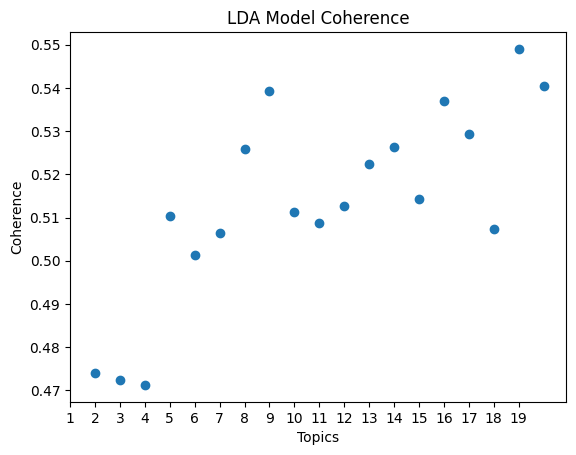

In [54]:
import matplotlib.pyplot as plt

plt.scatter(lda_tuning['Topics'], lda_tuning['Coherence'])
plt.xticks(range(1, 20))
plt.xlabel('Topics')
plt.ylabel('Coherence')
plt.title('LDA Model Coherence')
plt.show()

In [55]:
%%time
lda_tuning_best = lda_tuning.sort_values(by=['Coherence'], ascending=False).head(1)


tuned_topics = int(lda_tuning_best['Topics'].to_string(index=False))


# Since the values for Alpha and Beta can be float, symmetric and asymmetric, we will either strip or convert to float
try:
    tuned_alpha = float(lda_tuning_best['Alpha'].to_string(index=False))
except:
    tuned_alpha = lda_tuning_best['Alpha'].to_string(index=False).strip()
    

try:
    tuned_beta = float(lda_tuning_best['Beta'].to_string(index=False))
except:
    tuned_beta = lda_tuning_best['Beta'].to_string(index=False).strip()    
    
print(f'Best Parameters: Topics: {tuned_topics}, Alpha: {tuned_alpha}, Beta: {tuned_beta}')

Best Parameters: Topics: 19, Alpha: asymmetric, Beta: auto
CPU times: user 1.36 ms, sys: 598 µs, total: 1.96 ms
Wall time: 1.51 ms


In [58]:
%%time

tuned_lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=k,
                       random_state=100,
                       passes=10,
                       alpha=tuned_alpha,
                       eta=tuned_beta,
                       workers = 9)

coherence_model_lda = CoherenceModel(model=tuned_lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
print('\nCoherence Score: ', coherence_model_lda.get_coherence())


Coherence Score:  0.5351885044104818
CPU times: user 2.43 s, sys: 416 ms, total: 2.85 s
Wall time: 13.3 s


In [59]:
%%time
pprint(tuned_lda_model.print_topics())
doc_lda = tuned_lda_model[doc_term_matrix]

[(0,
  '0.020*"fall" + 0.012*"seattle_time" + 0.010*"close" + 0.008*"gain" + '
  '0.008*"news" + 0.005*"launch" + 0.005*"newsbreak" + 0.004*"visit" + '
  '0.003*"make" + 0.003*"support_page"'),
 (1,
  '0.027*"seattle_time" + 0.008*"stock" + 0.008*"techradar" + 0.008*"new" + '
  '0.007*"hackernoon" + 0.005*"game" + 0.005*"use" + 0.005*"announce" + '
  '0.004*"business" + 0.004*"hit"'),
 (2,
  '0.013*"newsbreak" + 0.007*"help" + 0.007*"share" + 0.006*"good" + '
  '0.006*"buy" + 0.005*"seattle_time" + 0.005*"game" + 0.005*"bnn_bloomberg" + '
  '0.005*"say" + 0.005*"start"'),
 (3,
  '0.028*"seattle_time" + 0.007*"get" + 0.007*"techradar" + 0.006*"year" + '
  '0.006*"rise" + 0.006*"report" + 0.005*"say" + 0.005*"newsbreak" + '
  '0.005*"man" + 0.005*"woman"'),
 (4,
  '0.024*"com" + 0.012*"newsbreak" + 0.010*"die" + 0.007*"age" + 0.007*"share" '
  '+ 0.006*"get" + 0.006*"sale" + 0.005*"buy" + 0.004*"become" + 0.004*"good"'),
 (5,
  '0.023*"seattle_time" + 0.009*"know" + 0.006*"newsbreak" + 0

In [60]:
%%time

lda_display = gensimvis.prepare(tuned_lda_model, doc_term_matrix, dictionary, sort_topics=False, mds='mmds',n_jobs=1)
pyLDAvis.display(lda_display)

CPU times: user 1.42 s, sys: 66.1 ms, total: 1.48 s
Wall time: 1.48 s


/Users/aayush/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


After reviewing the LDA results, I determined that N=13 was the optimal number of topics for analyzing the news text, despite the model indicating 16 topics. This decision was made due to significant overlap among the clusters.

Each identified topic reflects a group of words that commonly appear together in news articles. While there was potential to incorporate information from both the titles and the article text, I opted not to include titles in the analysis. This choice was influenced by the observation that titles are considerably shorter than the article text and often convey similar content. Consequently, the impact of titles on topic extraction was expected to be minimal.

Upon further examination, I observed overlap among topics 5, 8, and 3. After manually assessing these topics, I concluded that merging them could yield more coherent results. These topics encompassed discussions related to the stock market, gaming, local news, and community events.

# Tweets Data

In [3]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
def clean_tweet(tweet):
    tweet = tweet.lower()  # Convert to lowercase
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)  # Remove URLs
    tweet = re.sub(r'\@\w+|\#', '', tweet)  # Remove mentions and hashtags
    tweet = re.sub(r'[^\w\s]', '', tweet)  # Remove punctuation
    tweet = re.sub(r'\d+', '', tweet)  # Remove digits
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)  # Remove short words
    tweet = re.sub(r'\s+', ' ', tweet).strip()  # Remove extra whitespace
    tokens = word_tokenize(tweet)  # Tokenize
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    x=' '.join(tokens)
    return x


In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [6]:
tweets_df['text']=tweets_df['text'].apply(lambda x: clean_tweet(x))
data_list = tweets_df['text'].tolist()        
data_tokens = list(sent_to_words(data_list))

In [7]:
%%time

# bigram = gensim.models.Phrases(data_tokens, min_count=5, threshold=100)
# trigram = gensim.models.Phrases(bigram[data_tokens], threshold=100)

bigram = gensim.models.Phrases(data_tokens, min_count=1, threshold=1)
trigram = gensim.models.Phrases(bigram[data_tokens], threshold=1)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

CPU times: user 453 ms, sys: 12.2 ms, total: 465 ms
Wall time: 463 ms


In [8]:
%%time

stop_words = stopwords.words('english')

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

CPU times: user 1.46 ms, sys: 1.53 ms, total: 2.99 ms
Wall time: 1.8 ms


In [9]:
%%time

# Remove Stop Words
data_tokens_nostops = remove_stopwords(data_tokens)

# Create n-grams
data_words_bigrams = make_bigrams(data_tokens_nostops)
data_words_trigrams = make_trigrams(data_tokens_nostops)

# Combine tokens and n-grams
# data_tokens_cobnined = data_tokens_nostops + data_words_bigrams + data_words_trigrams
data_tokens_cobnined = data_words_trigrams

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Lemmatize text keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_tokens_cobnined, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


CPU times: user 22.2 s, sys: 155 ms, total: 22.4 s
Wall time: 22.5 s


In [10]:
%%time

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(data_lemmatized)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_lemmatized]

CPU times: user 118 ms, sys: 4.97 ms, total: 123 ms
Wall time: 122 ms


In [11]:
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=k,
                       random_state=100,                  
                       passes=5,
                       alpha=a,
                       eta=b,
                       workers=9)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [14]:
%%time

grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 20
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')
alpha = ['symmetric'] # Run for number of topics only

# Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')
beta = ['auto'] # Run for number of topics only


# Validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.5), 
#                gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.75), 
               #doc_term_matrix
              ]
# corpus_title = ['75% Corpus', '100% Corpus']
corpus_title = ['100% Corpus']
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')

    
# iterate through hyperparameters
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        tic()
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                itr += 1
                cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                pct_completed = round((itr / itr_total * 100),1)
#                 print(f'Completed Percent: {pct_completed}%, Corpus: {corpus_title[i]}, Topics: {k}, Alpha: {a}, Beta: {b}, Coherence: {cv}')
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
        tac()
                    
lda_tuning = pd.DataFrame(model_results)

LDA will execute 19 iterations
Completed model based on 2 LDA topics. Finished 5.3% of LDA runs
Execution time to calculate for topic 2: 0hour:0min:12sec
Completed model based on 3 LDA topics. Finished 10.5% of LDA runs
Execution time to calculate for topic 3: 0hour:0min:11sec
Completed model based on 4 LDA topics. Finished 15.8% of LDA runs
Execution time to calculate for topic 4: 0hour:0min:11sec
Completed model based on 5 LDA topics. Finished 21.1% of LDA runs
Execution time to calculate for topic 5: 0hour:0min:11sec
Completed model based on 6 LDA topics. Finished 26.3% of LDA runs
Execution time to calculate for topic 6: 0hour:0min:11sec
Completed model based on 7 LDA topics. Finished 31.6% of LDA runs
Execution time to calculate for topic 7: 0hour:0min:10sec
Completed model based on 8 LDA topics. Finished 36.8% of LDA runs
Execution time to calculate for topic 8: 0hour:0min:10sec
Completed model based on 9 LDA topics. Finished 42.1% of LDA runs
Execution time to calculate for topi

In [15]:
lda_tuning.sort_values(by=['Coherence'], ascending=False).head(10)


,Topics,Alpha,Beta,Coherence
0,2,symmetric,auto,0.479262
11,13,symmetric,auto,0.463660
2,4,symmetric,auto,0.459081
15,17,symmetric,auto,0.457490
17,19,symmetric,auto,0.455847
10,12,symmetric,auto,0.453066
14,16,symmetric,auto,0.451840
1,3,symmetric,auto,0.450516
9,11,symmetric,auto,0.445803
3,5,symmetric,auto,0.445313


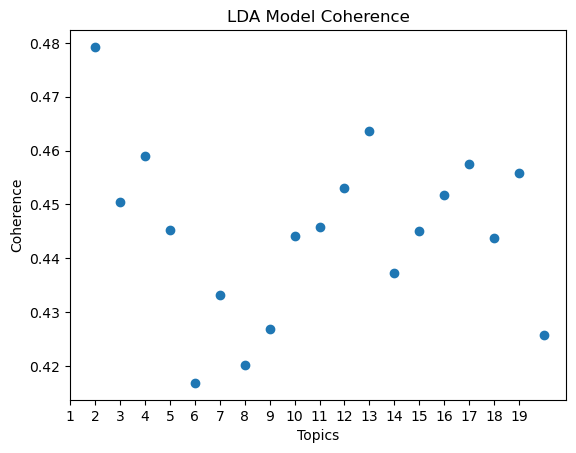

In [16]:
import matplotlib.pyplot as plt

plt.scatter(lda_tuning['Topics'], lda_tuning['Coherence'])
plt.xticks(range(1, 20))
plt.xlabel('Topics')
plt.ylabel('Coherence')
plt.title('LDA Model Coherence')
plt.show()

<Axes: xlabel='Topics'>

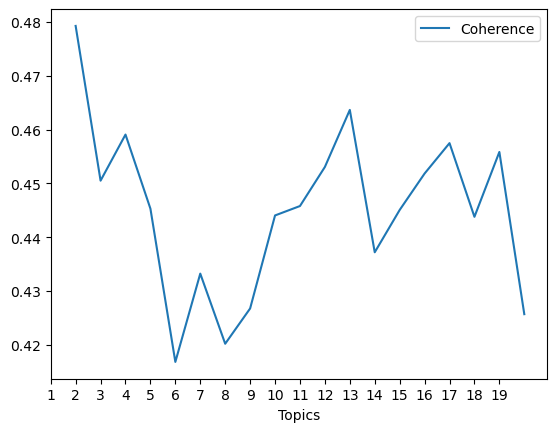

In [17]:
lda_tuning.plot(x ='Topics', y='Coherence', kind = 'line', xticks=range(1,20))


In [18]:
%%time
lda_tuning_best = lda_tuning.sort_values(by=['Coherence'], ascending=False).head(1)


tuned_topics = int(lda_tuning_best['Topics'].to_string(index=False))


# Since the values for Alpha and Beta can be float, symmetric and asymmetric, we will either strip or convert to float
try:
    tuned_alpha = float(lda_tuning_best['Alpha'].to_string(index=False))
except:
    tuned_alpha = lda_tuning_best['Alpha'].to_string(index=False).strip()
    

try:
    tuned_beta = float(lda_tuning_best['Beta'].to_string(index=False))
except:
    tuned_beta = lda_tuning_best['Beta'].to_string(index=False).strip()    
    
print(f'Best Parameters: Topics: {tuned_topics}, Alpha: {tuned_alpha}, Beta: {tuned_beta}')

Best Parameters: Topics: 2, Alpha: symmetric, Beta: auto
CPU times: user 2.93 ms, sys: 1.39 ms, total: 4.32 ms
Wall time: 3.84 ms


In [22]:
%%time

tuned_lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=tuned_topics,
                       random_state=100,
                       passes=10,
                       alpha=tuned_alpha,
                       eta=tuned_beta,
                       workers = 9)

coherence_model_lda = CoherenceModel(model=tuned_lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
print('\nCoherence Score: ', coherence_model_lda.get_coherence())


Coherence Score:  0.4375300351159977
CPU times: user 3.18 s, sys: 520 ms, total: 3.7 s
Wall time: 14.1 s


In [23]:
%%time
pprint(tuned_lda_model.print_topics())
doc_lda = tuned_lda_model[doc_term_matrix]

[(0,
  '0.007*"ever_ever_ever_ever" + 0.004*"game" + 0.003*"use" + 0.003*"work" + '
  '0.003*"year" + 0.003*"new" + 0.003*"say" + 0.003*"make" + 0.003*"day" + '
  '0.002*"update"'),
 (1,
  '0.005*"get" + 0.005*"know" + 0.004*"window" + 0.004*"company" + '
  '0.003*"learn" + 0.003*"microsoft" + 0.003*"make" + 0.003*"use" + '
  '0.003*"well" + 0.003*"microsoft_team"')]
CPU times: user 1.03 ms, sys: 995 µs, total: 2.02 ms
Wall time: 1.23 ms


In [24]:
%%time
fig= plt.figure(figsize = (10,10))
lda_display = gensimvis.prepare(tuned_lda_model, doc_term_matrix, dictionary, sort_topics=False, mds='mmds',n_jobs=1)
pyLDAvis.display(lda_display)

CPU times: user 1.04 s, sys: 30.5 ms, total: 1.07 s
Wall time: 1.06 s


<Figure size 1000x1000 with 0 Axes>

Upon examining the tweet data and implementing appropriate text cleaning techniques, I determined that having two topics, N=2, (according to the coherence scores), offers the most effective representation of tweet content.

The primary topic centers on the company Microsoft and related activities such as gaming, work, and product usage. This suggests that Twitter users are engaging in discussions about various facets of Microsoft's products, services, and operations, including gaming experiences and how they utilize the products. The secondary topic appears to pertain to premium accounts or subscriptions, indicating conversations regarding premium features, pricing, and subscription plans. This implies that users might be deliberating on Microsoft's premium offerings, different subscription models, and the potential advantages or disadvantages of opting for a premium account.